In [112]:
import json
import os
import re

In [113]:
#ściezka z danymi origin
input_folder_orig = r'C:\Users\Adam\Desktop\ONS\data\chopin\orig'

#lista plikow origin
file_list_orig = ['1.json', '2.json', '3.json', '4.json', '5.json', '6.json','7.json', '8.json', '9.json', '10.json', '11.json', '12.json']

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ścieżki do plików
airports_csv = r'C:\Users\Adam\Desktop\ONS\data\combined_iata_icao.csv'
countries_csv = r'C:\Users\Adam\Desktop\ONS\data\all.csv'

# Wczytanie danych lotnisk z pliku CSV
airports_df = pd.read_csv(airports_csv)
countries_df = pd.read_csv(countries_csv)

# Usunięcie dodatkowych znaków białych
countries_df['alpha-2'] = countries_df['alpha-2'].str.strip()

# Usunięcie cudzysłowów
countries_df['alpha-2'] = countries_df['alpha-2'].str.replace('"', '')

# Mapowanie krajów na pełne nazwy krajów
country_code_to_name = countries_df.set_index('alpha-2')['name'].to_dict()

# Sprawdzenie
#print(country_code_to_name)


# Mapowanie krajów na kod ICAO lotnisk
icao_to_country_code = airports_df.set_index('icao')['country_code'].to_dict()
country_code_to_name = countries_df.set_index('alpha-2')['name'].to_dict()
country_code_to_continent = countries_df.set_index('alpha-2')['region'].to_dict()
country_code_to_region = countries_df.set_index('alpha-2')['sub-region'].to_dict()


# Lista plików origin
input_folder_orig = r'C:\Users\Adam\Desktop\ONS\data\chopin\orig'
file_list_orig = ['1.json', '2.json', '3.json', '4.json', '5.json', '6.json', '7.json', '8.json', '9.json', '10.json', '11.json', '12.json']

# Tworzenie listy do przechowywania wyników
all_flights = []

# Przetwarzanie plików z listy origin
for filename in file_list_orig:
    input_file_path = os.path.join(input_folder_orig, filename)

    with open(input_file_path, 'r', encoding='utf-8') as infile:
        for line in infile:
            try:
                data = json.loads(line)
                all_flights.append(data)
            except json.JSONDecodeError:
                print(f"Błąd dekodowania JSON w pliku {filename}, linia: {line}")

# Konwersja listy do DataFrame
df = pd.DataFrame(all_flights)

# Konwersja kolumny 'pitr' do formatu datetime
df['pitr'] = pd.to_datetime(df['pitr'])

# Dodanie kolumny 'month' na podstawie 'pitr'
df['month'] = df['pitr'].dt.month

# Zastąpienie kodów ICAO kodami krajów
df['dest_country_code'] = df['dest'].map(icao_to_country_code).fillna(df['dest'])

# Zastąpienie kodow panstw, nazwami panstw
df['dest_country'] = df['dest_country_code'].map(country_code_to_name).fillna(df['dest_country_code'])

# Zastąpienie kodow panstw, kontynentami
df['dest_continent'] = df['dest_country_code'].map(country_code_to_continent).fillna(df['dest_country_code'])

# Zastąpienie kodow panstw,  regionami kontynentów
df['dest_region'] = df['dest_country_code'].map(country_code_to_region).fillna(df['dest_country_code'])




In [133]:
# Znalezienie niezmapowanych kodów ICAO
unmapped_icao = []

for icao_code in df['dest_country_code'].unique():
    if icao_code not in country_code_to_name:
        unmapped_icao.append(icao_code)

# Wypisanie niezmapowanych kodów ICAO
print("Niezmapowane kody ICAO:")
for icao_code in unmapped_icao:
    print(icao_code)


Niezmapowane kody ICAO:


In [134]:
# Mapowanie na pory roku
season_map = {
    1: 'Winter', 2: 'Winter', 3: 'Spring',
    4: 'Spring', 5: 'Spring', 6: 'Spring',
    7: 'Summer', 8: 'Summer', 9: 'Summer',
    10: 'Autumn', 11: 'Autumn', 12: 'Winter'
}
df['season'] = df['month'].map(season_map)

In [135]:
# Zliczenie ilości lotów z Polski do innych krajów w danym miesiącu
flights_from_poland_to_countries = df[df['orig'] == 'EPWA'].groupby(['season', 'dest_country']).size().reset_index(name='count')

# Wyświetlenie wyników
for season in df['season'].unique():
    for country in df['dest_country'].unique():
        flight_count = flights_from_poland_to_countries[
            (flights_from_poland_to_countries['season'] == season) & 
            (flights_from_poland_to_countries['dest_country'] == country)
        ]
        if not flight_count.empty:
            count = flight_count['count'].values[0]
            print(f"Liczba lotów z lotniska Chopina do kraju {country} w porze roku {season}: {count}")


Liczba lotów z lotniska Chopina do kraju Israel w porze roku Winter: 332
Liczba lotów z lotniska Chopina do kraju Japan w porze roku Winter: 61
Liczba lotów z lotniska Chopina do kraju Qatar w porze roku Winter: 204
Liczba lotów z lotniska Chopina do kraju United Kingdom of Great Britain and Northern Ireland w porze roku Winter: 1027
Liczba lotów z lotniska Chopina do kraju France w porze roku Winter: 717
Liczba lotów z lotniska Chopina do kraju Russian Federation w porze roku Winter: 577
Liczba lotów z lotniska Chopina do kraju Czechia w porze roku Winter: 495
Liczba lotów z lotniska Chopina do kraju Spain w porze roku Winter: 447
Liczba lotów z lotniska Chopina do kraju Netherlands, Kingdom of the w porze roku Winter: 652
Liczba lotów z lotniska Chopina do kraju Sweden w porze roku Winter: 404
Liczba lotów z lotniska Chopina do kraju Romania w porze roku Winter: 330
Liczba lotów z lotniska Chopina do kraju Austria w porze roku Winter: 419
Liczba lotów z lotniska Chopina do kraju Pola

In [136]:
# Zliczenie ilości lotów z Polski do roznych kontynentow w kazdym miesiacu
flights_from_poland_to_continents = df[df['orig'] == 'EPWA'].groupby(['season', 'dest_continent']).size().reset_index(name='count')

# Wyświetlenie wyników
for season in df['season'].unique():
    for continent in df['dest_continent'].unique():
        flight_count = flights_from_poland_to_continents[
            (flights_from_poland_to_continents['season'] == season) & 
            (flights_from_poland_to_continents['dest_continent'] == continent)
        ]
        if not flight_count.empty:
            count = flight_count['count'].values[0]
            print(f"Liczba lotów z lotniska Chopin do kontynentu {continent} w miesiącu {season}: {count}")

Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Winter: 1399
Liczba lotów z lotniska Chopin do kontynentu Europe w miesiącu Winter: 15619
Liczba lotów z lotniska Chopin do kontynentu Americas w miesiącu Winter: 459
Liczba lotów z lotniska Chopin do kontynentu Africa w miesiącu Winter: 103
Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Spring: 2347
Liczba lotów z lotniska Chopin do kontynentu Europe w miesiącu Spring: 23384
Liczba lotów z lotniska Chopin do kontynentu Americas w miesiącu Spring: 665
Liczba lotów z lotniska Chopin do kontynentu Africa w miesiącu Spring: 150
Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Summer: 2087
Liczba lotów z lotniska Chopin do kontynentu Europe w miesiącu Summer: 21680
Liczba lotów z lotniska Chopin do kontynentu Americas w miesiącu Summer: 757
Liczba lotów z lotniska Chopin do kontynentu Africa w miesiącu Summer: 167
Liczba lotów z lotniska Chopin do kontynentu Asia w miesiącu Autumn: 969
Liczba lotów z lot

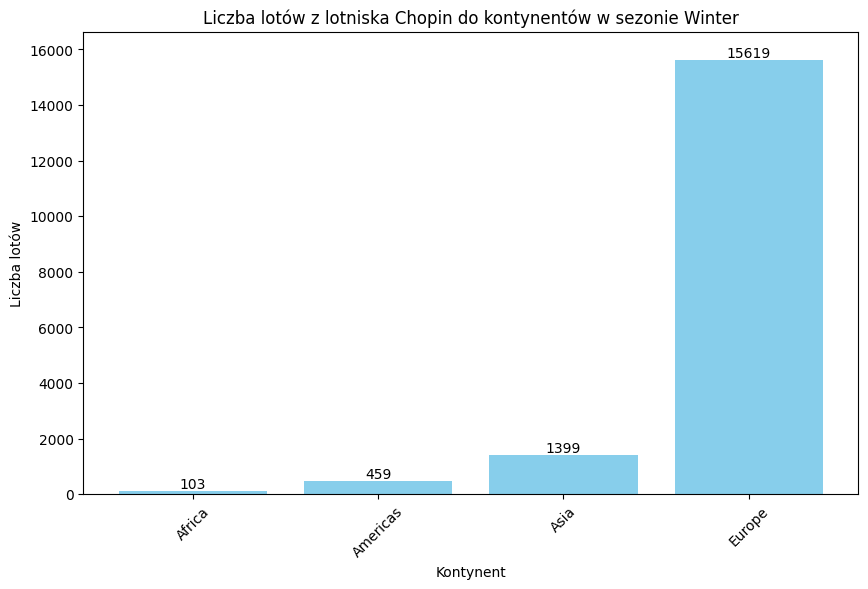

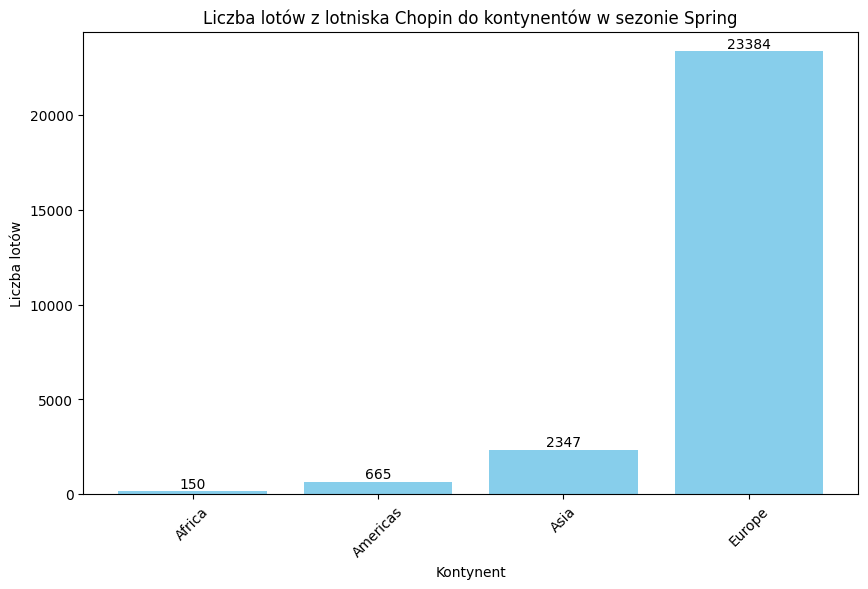

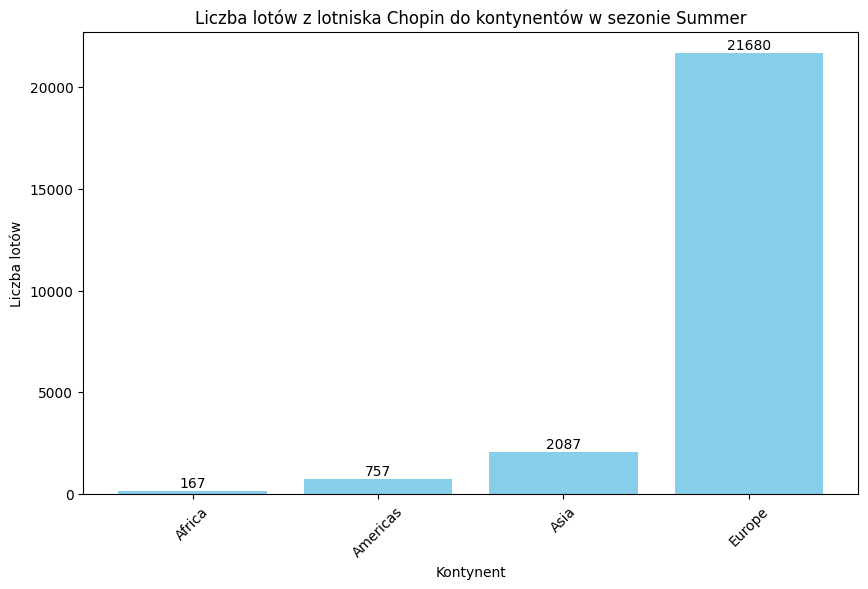

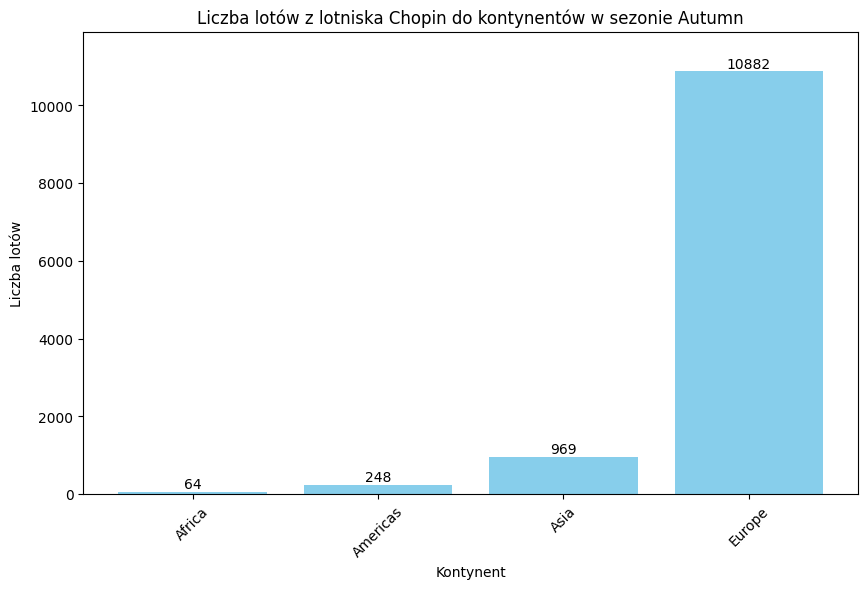

In [163]:
import matplotlib.pyplot as plt

# Zliczenie ilości lotów z Polski do różnych kontynentów w każdej porze roku
flights_from_poland_to_continents = df[df['orig'] == 'EPWA'].groupby(['season', 'dest_continent']).size().reset_index(name='count')

# Lista pór roku
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

# Tworzenie wykresów dla każdej pory roku
for season in seasons:
    # Przygotowanie danych do wykresu dla wybranej pory roku
    continent_counts = flights_from_poland_to_continents[flights_from_poland_to_continents['season'] == season]

    # Tworzenie wykresu kolumnowego
    plt.figure(figsize=(10, 6))
    bars = plt.bar(continent_counts['dest_continent'], continent_counts['count'], color='skyblue')
    plt.title(f'Liczba lotów z lotniska Chopin do kontynentów w sezonie {season}')
    plt.xlabel('Kontynent')
    plt.ylabel('Liczba lotów')
    plt.xticks(rotation=45)
    plt.ylim(0, continent_counts['count'].max() + 1000)  # Ustawienie górnej granicy osi y z większą przestrzenią

    # Dodanie etykiet nad każdą kolumną
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

    # Wyświetlenie wykresu dla aktualnej pory roku
    plt.show()


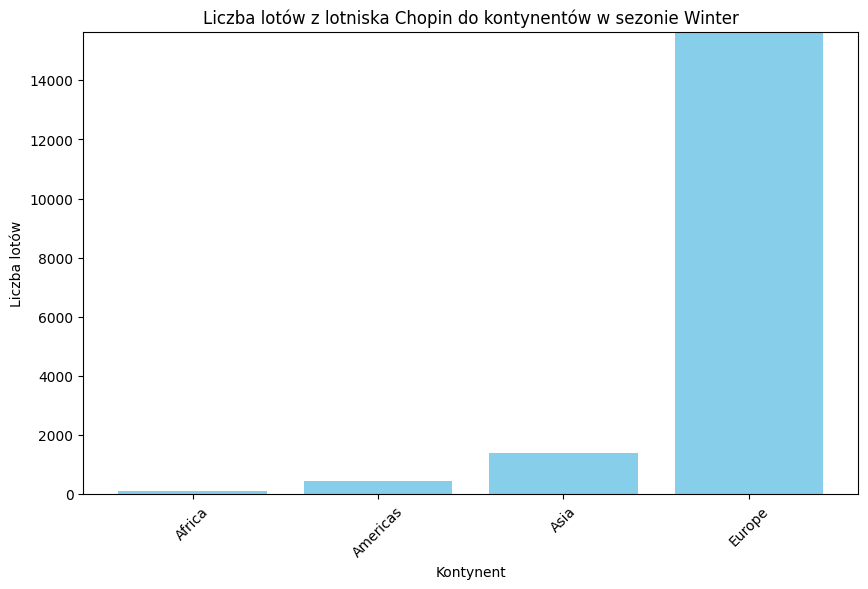

In [157]:
# Wybór jednej pory roku, np. 'Winter'
season = 'Winter'

# Przygotowanie danych do wykresu dla wybranej pory roku
continent_counts = flights_from_poland_to_continents[flights_from_poland_to_continents['season'] == season]

# Tworzenie wykresu kolumnowego
plt.figure(figsize=(10, 6))
plt.bar(continent_counts['dest_continent'], continent_counts['count'], color='skyblue')
plt.title(f'Liczba lotów z lotniska Chopin do kontynentów w sezonie {season}')
plt.xlabel('Kontynent')
plt.ylabel('Liczba lotów')
plt.xticks(rotation=45)
plt.ylim(0, continent_counts['count'].max() + 10)  # Ustawienie górnej granicy osi y

# Wyświetlenie wykresu
plt.show()


In [142]:
# Zliczenie ilości lotów z Polski do różnych regionów w każdej porze roku
flights_from_poland_to_regions = df[df['orig'] == 'EPWA'].groupby(['season', 'dest_region']).size().reset_index(name='count')

# Wyświetlenie wyników
for season in df['season'].unique():
    for region in df['dest_region'].unique():
        flight_count = flights_from_poland_to_regions[
            (flights_from_poland_to_regions['season'] == season) & 
            (flights_from_poland_to_regions['dest_region'] == region)
        ]
        if not flight_count.empty:
            count = flight_count['count'].values[0]
            #print(f"Liczba lotów z lotniska Chopin do regionu {region} w porze roku {season}: {count}")


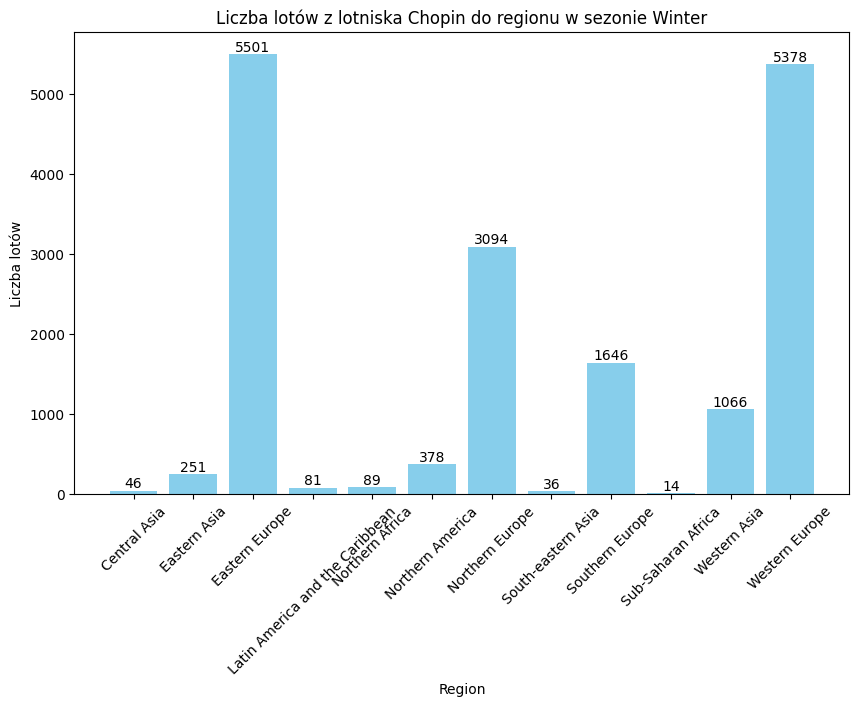

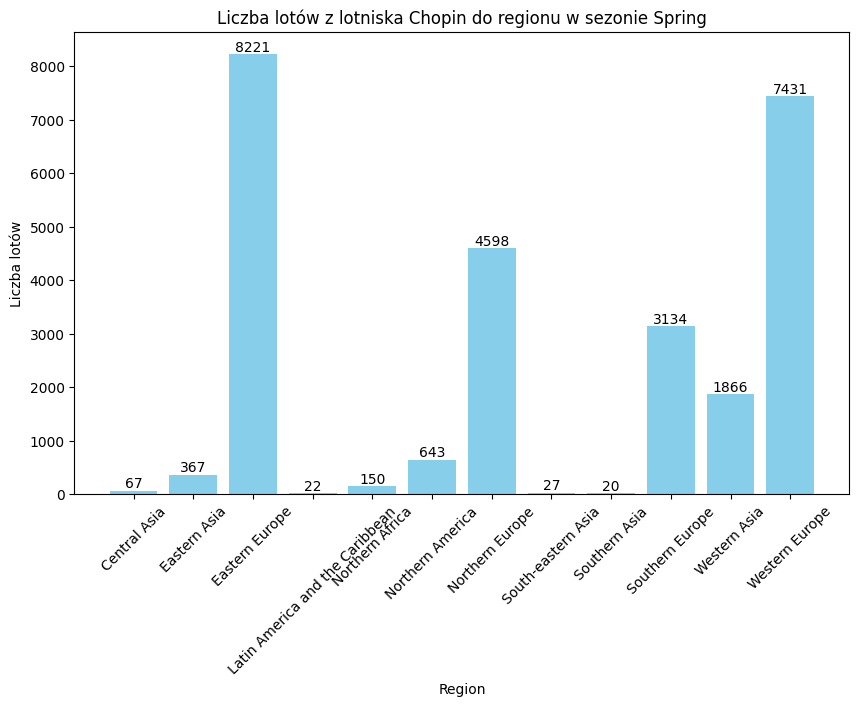

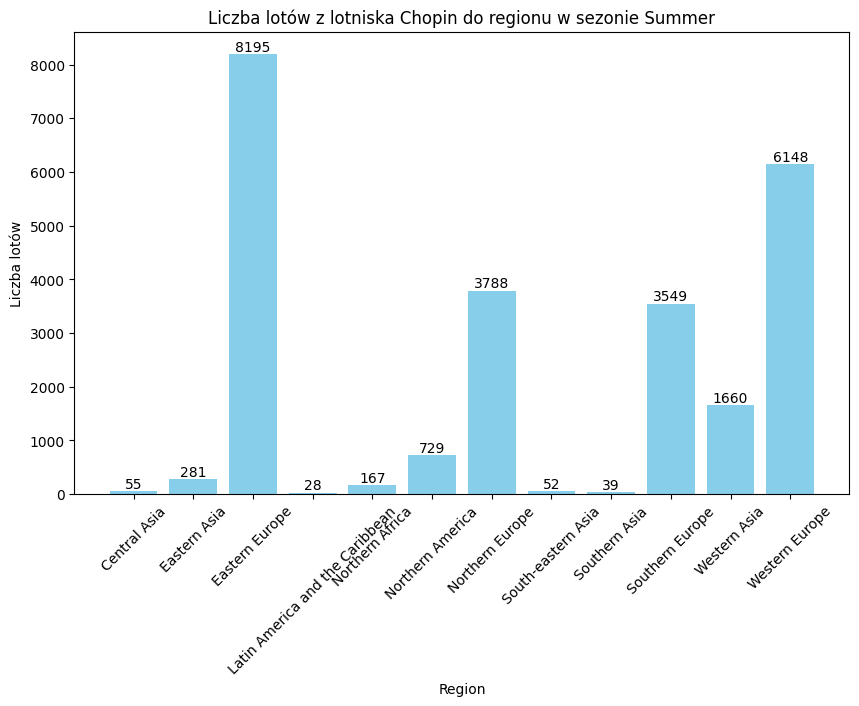

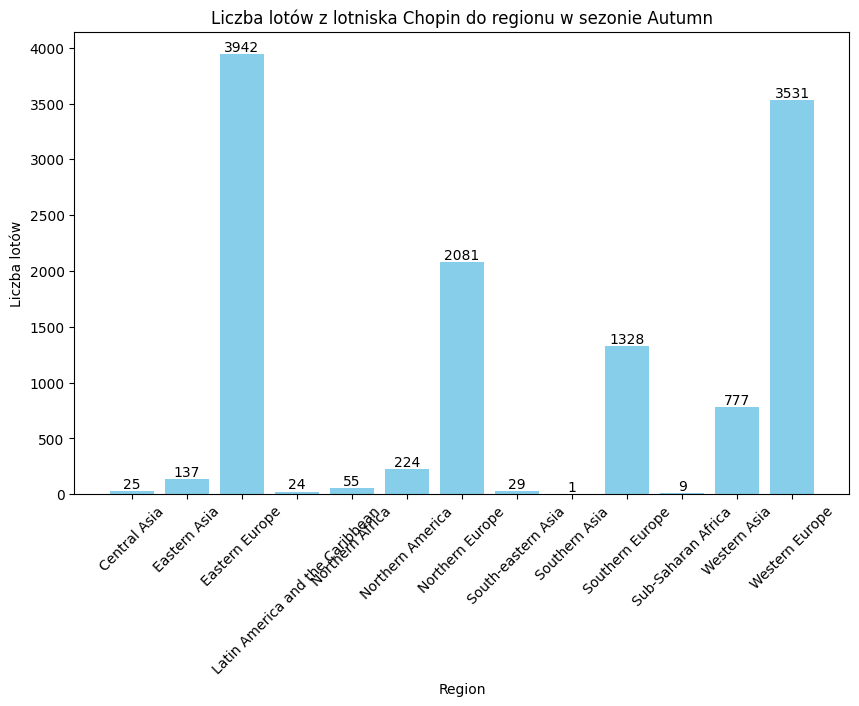

In [156]:
# Tworzenie wykresów dla każdej pory roku
for season in seasons:
    # Przygotowanie danych do wykresu dla wybranej pory roku
    region_counts = flights_from_poland_to_regions[flights_from_poland_to_regions['season'] == season]

    # Tworzenie wykresu kolumnowego
    plt.figure(figsize=(10, 6))
    bars = plt.bar(region_counts['dest_region'], region_counts['count'], color='skyblue')
    plt.title(f'Liczba lotów z lotniska Chopin do regionu w sezonie {season}')
    plt.xlabel('Region')
    plt.ylabel('Liczba lotów')
    plt.xticks(rotation=45)
   # plt.ylim(0, continent_counts['count'].max() + 20)  # Ustawienie górnej granicy osi y z większą przestrzenią
    # Dodanie etykiet nad każdą kolumną
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')

    # Wyświetlenie wykresu
    plt.show()

In [155]:
unique_countries_per_month = flights_from_poland_per_month.groupby('month')['dest_country_code'].nunique().reset_index(name='unique_countries')
# Wyświetlanie wyników
for index, row in unique_countries_per_month.iterrows():
    month = row['month']
    unique_countries = row['unique_countries']
    print(f"Ilość państw: {unique_countries} do których wykonano połączenia z lotniska Chopin w miesiącu {month} ")

Ilość państw: 59 do których wykonano połączenia z lotniska Chopin w miesiącu 1 
Ilość państw: 58 do których wykonano połączenia z lotniska Chopin w miesiącu 2 
Ilość państw: 57 do których wykonano połączenia z lotniska Chopin w miesiącu 3 
Ilość państw: 50 do których wykonano połączenia z lotniska Chopin w miesiącu 4 
Ilość państw: 54 do których wykonano połączenia z lotniska Chopin w miesiącu 5 
Ilość państw: 55 do których wykonano połączenia z lotniska Chopin w miesiącu 6 
Ilość państw: 60 do których wykonano połączenia z lotniska Chopin w miesiącu 7 
Ilość państw: 56 do których wykonano połączenia z lotniska Chopin w miesiącu 8 
Ilość państw: 59 do których wykonano połączenia z lotniska Chopin w miesiącu 9 
Ilość państw: 56 do których wykonano połączenia z lotniska Chopin w miesiącu 10 
Ilość państw: 62 do których wykonano połączenia z lotniska Chopin w miesiącu 11 
Ilość państw: 63 do których wykonano połączenia z lotniska Chopin w miesiącu 12 


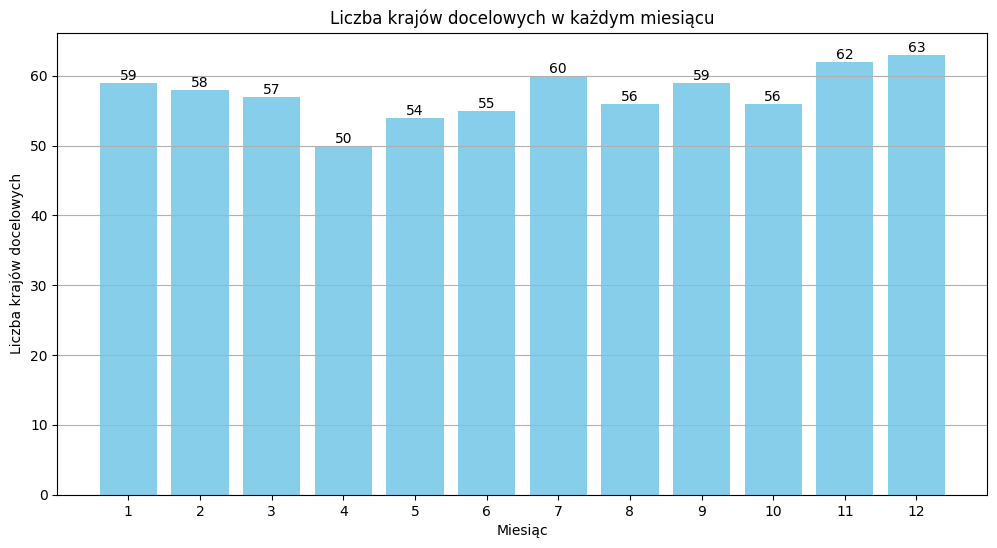

In [55]:
# Tworzenie wykresu kolumnowego
plt.figure(figsize=(12, 6))
bars = plt.bar(unique_countries_per_month['month'], unique_countries_per_month['unique_countries'], color='skyblue')

# Dodanie etykiet nad każdą kolumną
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.xlabel('Miesiąc')
plt.ylabel('Liczba krajów docelowych')
plt.title('Liczba krajów docelowych w każdym miesiącu')
plt.xticks(range(1, 13))  # Ustawienie etykiet osi X na miesiące od 1 do 12
plt.grid(True, axis='y')
plt.show()
